# Lineare Klassifikation und logistische Regression

Gegeben seien folgende Daten:

$$
\begin{aligned}
    x_{1,i} &= [1,4,7,6,1,5] \\
    𝑥_{2,i} &= [2,8,14,10,0,9] \\
    y_i &= [0,1,1,0,1,0] \\
\end{aligned}
$$

In [32]:
import numpy as np
np.set_printoptions(precision=4, suppress=True)

x1 = np.array([4,9,5,5,0,9])
x2 = np.array([1,9,5,4,-2,7])
y = np.array([1,0,0,1,1,0])

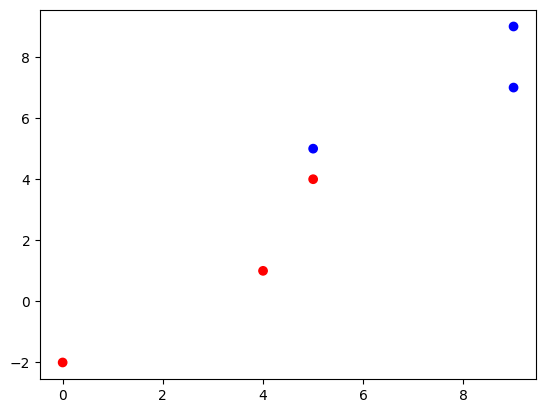

In [33]:
import matplotlib.pyplot as plt

plt.scatter(x1, x2, c=y, cmap='bwr')
plt.show()

## Aufgabe 1: Lineare Klassifikation mittels kleinste-Quadrate

Berechnen Sie mittels kleinste-Quadrate-Rechnung eine **lineare Klassifikation**
der Form

$$
\hat{y} = h\left( p\left( x_1, x_2\right)\right) \newline
p\left(x_1,x_2\right) = w_0 + w_1 x_1 + w_2 x_2 \text{ mit }
h\left(z\right) = \begin{cases} 1 &, z\ge 0.5 \\ 0 &, z < 0.5 \end{cases}
$$

und geben Sie die Funktionsgleichung der Entscheidungsgrenze
$x_2 = \ldots \cdot x_1 + \ldots$ an.

### Gewichte

In [34]:
n = y.shape[0]
A = np.vstack([np.ones(n), x1, x2]).T
print(A)

[[ 1.  4.  1.]
 [ 1.  9.  9.]
 [ 1.  5.  5.]
 [ 1.  5.  4.]
 [ 1.  0. -2.]
 [ 1.  9.  7.]]


In [35]:
W = np.linalg.lstsq(A, y, rcond=None)[0]
print(W)

[ 0.806   0.0691 -0.1687]


In [6]:
theta = 0.5

def predict(X):
    z = X @ W
    y_hat = np.zeros(X.shape[0])
    y_hat[z >= theta] = 1
    return y_hat

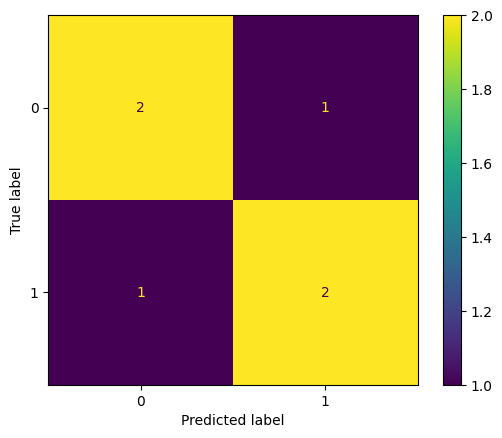

In [8]:
import sklearn.metrics

y_hat = predict(A)
_ = sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y, y_hat)

### Entscheidungsgrenze

$$
\begin{aligned}
    B &= \{ \mathbf{x} \in \mathbb{R}^\ell ~|~ \mathbf{x}^{\operatorname{T}}
        \mathbf{w} = b + w_1x_1 + w_2x_2 + \ldots + w_\ell x_\ell = \theta \} \\

    \Rightarrow \theta &= p(\mathbf{x}) = w_0 + w_1x_1 + w_2x_2 \\
\end{aligned}
$$

In [36]:
from sympy import Eq, symbols, solve

s_x1, s_x2, s_y = symbols('x1 x2 y')
eqn = Eq(W[0] + W[1] * s_x1 + W[2] * s_x2, theta)

solve(eqn, s_x2)

[0.409836065573771*x1 + 1.81420765027323]

## Aufgabe 2: Logistische Regression

Nun soll eine logistische Regression durchgeführt werden. Ein Prädiktor

$$
\hat{y} = \begin{cases} 1 &,~\phi\ge0.5 \\ 0 &,~\phi<0.5 \end{cases}
$$

wird mittels einem Klassifikationsmodell der Form

$$
\phi = \phi\left( p\left( x_1, x_2\right)\right) \newline
p(x_1,x_2) = w_0 + w_1x_1 + w_2x_2 \text{ mit } \phi(z) = \operatorname{Sigmoid}
$$

berechnet. Dazu muss die *gemittelte* Cross-Entropie als Zielfunktion minimiert
werden.

Führen Sie für diese Aufgabe 5 Schritte des Gradienten-Abstiegs-Verfahrens mit
Schrittweite $\alpha = 0.1$ aus. Benutzen Sie den Startvektor
$\mathbf{w}^{(0)} = [-1, 0, 0]^\intercal$.

*gemittelte Cross-Entropie* (V8, F3)

$$
f\left(\mathbf{x}\right) = -\frac1n \sum_{j=1}^n \left(
    y_j \ln \phi\left(p\left(\mathbf{x}_j\right)\right) +
    \left(1 - y_j\right) \ln \left(1  \phi\left(p\left(\mathbf{x}_j\right)\right)\right)
\right) \to \min
$$

In [37]:
alpha = 0.1
w0 = np.array([-1, 0, 0])
max_it = 5

In [38]:
# V8 F8
def sigmoid(z):
    positives = z >= 0
    negatives = ~positives
    
    y = z.copy()
    y[positives] = 1 / (1 + np.exp(-z[positives]))
    
    exp_z_neg = np.exp(z[negatives])
    y[negatives] = exp_z_neg / (1 + exp_z_neg)
    
    return y

# V8 F3+8 / `V8_Klassifikation-Bsp.ipynb`
def cost_fun_cross_entropy(w, X, y):
    z = X @ w
    n = X.shape[0]
    p = sigmoid(z)
    
    pos = y==1
    neg = ~pos
    
    s1 = y[pos] * np.log(p[pos])
    s2 = (1 - y[neg]) * np.log(1 - p[neg])
    
    return -s1.sum() / n - s2.sum() / n

# V8 F6
def gradient(w, X, y):
    z = X @ w
    p = sigmoid(z)
    n = X.shape[0]
    return X.T @ (p - y) / n

In [39]:
# V8 F7
def gd(w0, X, y, grad_fun, cost_fun, alpha, max_it):
    w = w0
    norm_grad = np.zeros(max_it)
    loss = np.zeros(max_it)
    n = X.shape[0]
    
    for k in range(max_it):
        grad = grad_fun(w, X, y)
        norm_grad[k] = np.linalg.norm(grad) / n
        loss[k] = cost_fun(w, X, y)
        w = w - alpha * grad
    
    return w, norm_grad, loss

In [40]:
W_log, norm_grad, loss = gd(w0=w0, X=A, y=y,
                            grad_fun=gradient,
                            cost_fun=cost_fun_cross_entropy,
                            alpha=alpha, max_it=max_it)
print(W_log)

[-0.8781  0.119  -0.1946]


In [41]:
print('W    ', W_log)
print('||g||', norm_grad)
print('f    ', loss)

W     [-0.8781  0.119  -0.1946]
||g|| [0.104  0.089  0.0858 0.0832 0.0807]
f     [0.8133 0.7805 0.7526 0.7265 0.702 ]
